In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import time
from english_words import english_words_set

## Conjuntos de Palabras

In [37]:
N=100
array=[set()]*N
i=0
for x in english_words_set:
    if i<N:
        if i==0:
            array[i]={x}
        else:
            array[i]=array[i-1].union({x})
    i=i+1
for i in np.arange(len(array)-1):
    if not array[i].issubset(array[i+1]):
        print("ERROR")
H=(1,1)
vert=np.array(array).reshape(N,1)
horz=np.array(array).reshape(1,N)

In [24]:
array

[{'annal'},
 {'annal', 'contributory'},
 {'annal', 'bonanza', 'contributory'},
 {'annal', 'bonanza', 'contributory', 'roister'},
 {'annal', 'bonanza', 'contributory', 'dam', 'roister'},
 {'annal', 'bonanza', 'contributory', 'dam', 'echinoderm', 'roister'},
 {'annal',
  'bonanza',
  'contributory',
  'dam',
  'echinoderm',
  'homeopath',
  'roister'},
 {'annal',
  'bonanza',
  'contributory',
  'dam',
  'echinoderm',
  'homeopath',
  'noon',
  'roister'},
 {'annal',
  'bonanza',
  'contributory',
  'dam',
  'echinoderm',
  'homeopath',
  'noon',
  'nude',
  'roister'},
 {'Guiana',
  'annal',
  'bonanza',
  'contributory',
  'dam',
  'echinoderm',
  'homeopath',
  'noon',
  'nude',
  'roister'},
 {'Guiana',
  'annal',
  'bonanza',
  'contributory',
  'dam',
  'dolce',
  'echinoderm',
  'homeopath',
  'noon',
  'nude',
  'roister'},
 {'Guiana',
  'annal',
  'bonanza',
  'contributory',
  'dam',
  'dolce',
  'echinoderm',
  'homeopath',
  'noon',
  'nude',
  'roister',
  'wig'},
 {'Guiana'

In [25]:
def kernel_u(w):
    """
    univariate gaussian kernel
    
    Arguments:
    w :: float
    
    returns:
    float
    N(0,1)(w) mean zero unit variance normal distribution on w
    """
    return np.exp(-0.5*w**2)/np.sqrt(2*np.pi)
def kernel_b(u,v):
    """
    bivariate gaussian kernel
    
    Arguments:
    u,v :: float
    
    returns:
    float
    N(0,0,1,1,0)(u,v) bivariate standard normal distribution on (u,v)
    """
    return np.exp(-0.5*(u**2 + v**2))/np.sqrt(2*np.pi)
def d(x,y):
    """
    Metric function
    
    Arguments:
    x,y sets
    
    returns:
    float
    the distance between x and y elements of a metric space
    """
    return len(x.symmetric_difference(y))
d_vec=np.vectorize(d)
"""
vectorized metric function d(X,Y)
Arguments
X :: set
Y :: array sets

returns:
array float
the distance between X and ith Y' entry 
"""

"\nvectorized metric function d(X,Y)\nArguments\nX :: set\nY :: array sets\n\nreturns:\narray float\nthe distance between X and ith Y' entry \n"

In [26]:
def old_density_est(V,W):
    n=len(array)
    sum=0       # sum to calculate density estimator
    for i in np.arange(0,n):
        u = d(V,array[i])/H[0]  # compute the fisrt parameter to pass to bivariate kernel
        v = d(W,array[i])/H[1]  # compute the second parameter to pass to bivariate kernel
        sum+=kernel_b(u,v)     #sum the kernel estimations
    return sum/(n*H[0]*H[1]) # return the mean of kernel estimations times det of bandwitdh matrix
def density_est(V,W):
    array1=kernel_u(d_vec(V,horz)/H[0])
    array2=kernel_u(d_vec(vert,W)/H[1])
    return np.dot(array1,array2)/(len(array)*H[0]*H[1]) # return the mean of kernel estimations times det of bmatrix
###################################################################################################################
###################################################################################################################
###################################################################################################################
def old_marginal_est(W):
    sum=0       # sum to calculate density estimator
    for V in array:
        sum+=old_density_est(V,W) #sum the kernel estimations
    return sum
def marginal_est(W):
    arr=density_est(vert,W) #sum the kernel estimations
    return np.sum(arr)
def conditional_prob(V,W):
    return density_est(V,W)/marginal_est(W)

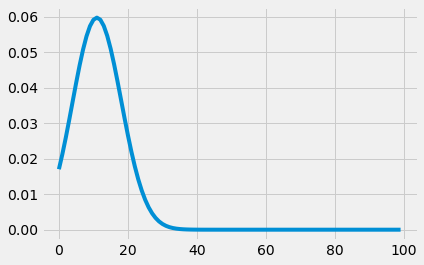

In [27]:
plt.plot(conditional_prob(vert,array[11]))

In [15]:
for n in range(5):
    %timeit old_density_est(array[n],array[287])
    %timeit density_est(array[n],array[287])
    %timeit old_marginal_est(array[n])
    %timeit marginal_est(array[n])
    print("==========================")

7.07 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.81 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.73 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.65 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.86 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.3 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.84 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.56 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.16 ms ± 88.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.05 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.87 s ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.62 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.14 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.7 s ± 169 ms per loop (m

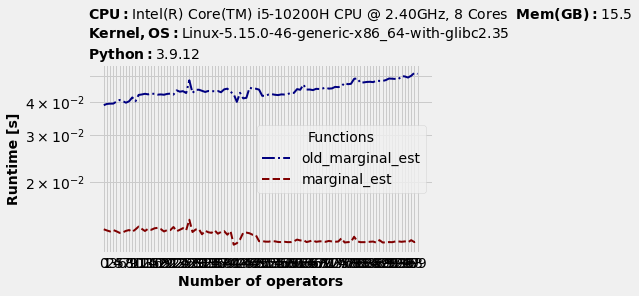

In [28]:
import benchit
funcs = [old_marginal_est, marginal_est]
inputs = {n: array[n] for n in range(N)}

t = benchit.timings(funcs, inputs, input_name='Number of operators')
t.plot()

## Plots

Text(0.0, 1.0, 'Marginal calculada con el nuevo estimador')

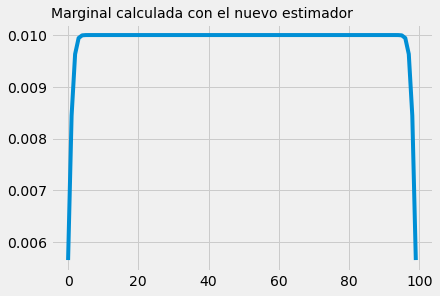

In [38]:
output=np.zeros(len(array))
for i in np.arange(len(array)):
    output[i]=marginal_est(array[i])
plt.plot(output)
plt.title("Marginal calculada con el nuevo estimador")

Text(0.0, 1.0, 'Densidad calculada con el nuevo estimador')

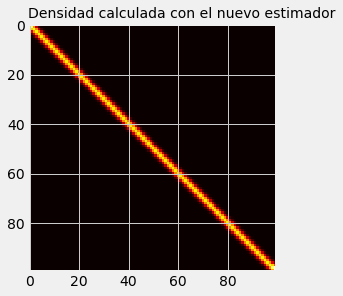

In [39]:
heatmap=np.zeros((len(array),len(array)))
bandwidth_matrix=[100,100]
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=density_est(array[i],array[j])/marginal_est(array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title("Densidad calculada con el nuevo estimador")

Text(0.0, 1.0, 'Densidad calculada con el nuevo estimador')

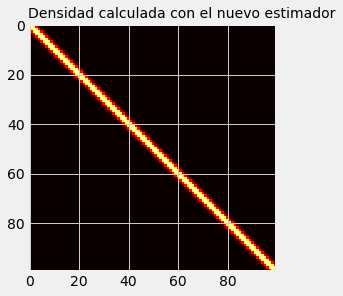

In [40]:
heatmap=np.zeros((len(array),len(array)))
bandwidth_matrix=[100,100]
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=density_est(array[i],array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title("Densidad calculada con el nuevo estimador")

Text(0.0, 1.0, 'Densidad calculada con el nuevo estimador')

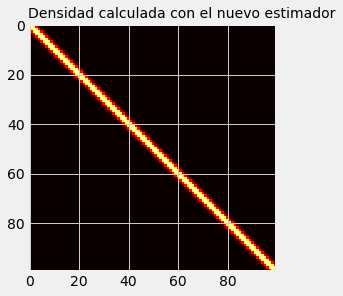

In [41]:
heatmap=np.zeros((len(array),len(array)))
bandwidth_matrix=[100,100]
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=old_density_est(array[i],array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title("Densidad calculada con el nuevo estimador")

In [ ]:
    @property
    def bandwidth(self):
        return self._bandwidth
    @bandwidth.setter
    def bandwidth(self, value):
        if not isinstance(value, float):
            raise TypeError('RandomSets.bandwidth must be a float')

            self._bandwidth = value